In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle
from jmespath import search
import time
import pandas as pd
import functools
import operator
from tqdm import tqdm, trange

In [2]:
data_path = 'data/'
model_path = 'models/'
fig_path = 'fig/'

In [3]:
with open(data_path + 'noisy_data.pkl','rb') as f:
    data = pickle.load(f)

In [4]:
len(data)

940

## PASSO 2: Cálculo dos cumulantes dos sinais

Funções para cálculo dos cumulantes:



In [5]:
# OBS: Somente as três últimas funções são utilizadas, as primeiras são apenas
# funções auxiliares.

def cum2Calc(vetMediaZero, nPoints, ii):
	return np.matmul(vetMediaZero.T, np.roll(vetMediaZero, ii))/nPoints

def cum3Calc(vetMediaZero, nPoints, ii):
	return np.matmul(vetMediaZero.T, np.roll(vetMediaZero, ii)**2)/nPoints

def cum4Calc(vetMediaZero, nPoints, ii):
	sumOfSquares = np.dot(vetMediaZero.T, vetMediaZero)
	part1 = np.matmul(vetMediaZero.T, np.roll(vetMediaZero, ii)**3)/nPoints
	part2 = 3*np.matmul(vetMediaZero.T, np.roll(vetMediaZero, ii))*sumOfSquares/(nPoints**2)
	cum4 = part1 - part2
	return cum4

def cumCalc(vetEntrada, nEvents, order):

	if (order == 2): 
		functionCalled = cum2Calc
	elif (order == 3):
		functionCalled = cum3Calc
	elif (order==4):
		functionCalled = cum4Calc
	else:
		return

	# Transformando vetEntrada em um vetor coluna:
	dimVet = vetEntrada.shape
	if(dimVet[0]==nEvents):   
		vetEntrada = vetEntrada.T

	nPoints = vetEntrada[:,0].size  # number of points per column
	
	# Pre - allocating space
	cum = np.zeros([nEvents, nPoints])

	for i in range(nEvents):
		# Transformando vetEntrada em um vetor de média nula:
		media = np.mean(vetEntrada[:,i])
		vetMediaZero = vetEntrada[:,i] - media

		for ii in range(nPoints):
			cum[i,ii] = functionCalled(vetMediaZero, nPoints, ii)

	return cum

def cum2(vetEntrada, nEvents):
	return cumCalc(vetEntrada, nEvents, 2)

def cum3(vetEntrada, nEvents):
	return cumCalc(vetEntrada, nEvents, 3)

def cum4(vetEntrada, nEvents):
	return cumCalc(vetEntrada, nEvents, 4)
 
def drange(start, stop, step):
    while start < stop:
            yield start
            start *= step

In [6]:
data[0].keys()

dict_keys(['fault_type', 'cycle_1', 'cycle_2', 'cycle_4', 'cycle_8', 'cycle_16', 'cycle_32', 'fault_type_bin'])

In [7]:
data[0]['cycle_1'].keys()

dict_keys(['I_pu', 'I_10db', 'I_20db', 'I_30db', 'I_40db', 'I_50db', 'I_60db', 'I_70db', 'I_80db', 'I_90db', 'I_100db'])

In [8]:
data[0]['fault_type']

'BCT'

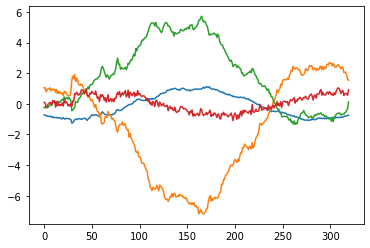

In [9]:
plt.plot(data[0]['cycle_1']['I_30db'])
plt.show()

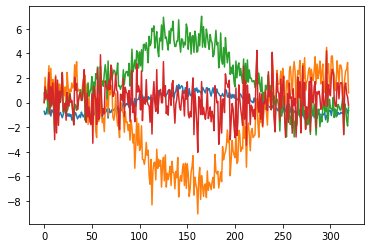

In [10]:
plt.plot(data[0]['cycle_1']['I_10db']);
plt.show()

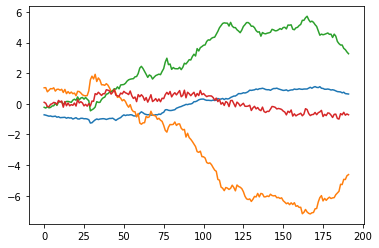

In [11]:
plt.plot(data[0]['cycle_2']['I_30db'])
plt.show()

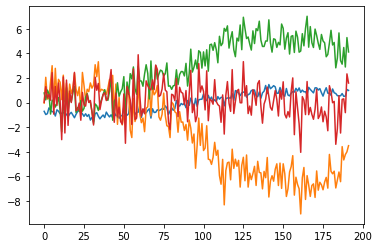

In [12]:
plt.plot(data[0]['cycle_2']['I_10db'])
plt.show()

In [13]:
key_list = []
for key in data[0].keys():
    if 'cycle' in key:
        key_list.append([key + '.' + k for k in data[0]['cycle_1'].keys()])

In [14]:
data[0].keys()

dict_keys(['fault_type', 'cycle_1', 'cycle_2', 'cycle_4', 'cycle_8', 'cycle_16', 'cycle_32', 'fault_type_bin'])

In [15]:
types = search("[*].fault_type", data)
types = pd.Series(types, name='fault_type')

types_bin = search("[*].fault_type_bin", data)
types_bin = pd.Series(types_bin, name='fault_type_bin')

In [16]:
key_list = functools.reduce(operator.iconcat, key_list, [])

In [17]:
types

0      BCT
1      CAT
2       CA
3      ABC
4       CT
      ... 
935    CAT
936     AT
937    BCT
938     BT
939    ABT
Name: fault_type, Length: 940, dtype: object

In [18]:
types_bin

0         A  B  C  T
0  0  1  1  1
1         A  B  C  T
0  1  0  1  1
2         A  B  C  T
0  1  0  1  0
3         A  B  C  T
0  1  1  1  0
4         A  B  C  T
0  0  0  1  1
                  ...             
935       A  B  C  T
0  1  0  1  1
936       A  B  C  T
0  1  0  0  1
937       A  B  C  T
0  0  1  1  1
938       A  B  C  T
0  0  1  0  1
939       A  B  C  T
0  1  1  0  1
Name: fault_type_bin, Length: 940, dtype: object

In [19]:
from tqdm import tqdm, trange

In [20]:
timeStart = time.perf_counter()
types = search("[*].fault_type", data)
cum_data_dict = {}
for key in tqdm(key_list, desc='key_list'):
    src = f"[*].{key}"
    signal = search(src, data)

    signal_a_list = []
    signal_b_list = []
    signal_c_list = []
    signal_z_list = []
    for i in range(len(signal)):
        signal_a_list.append(signal[i][:,0].reshape(1,-1))
        signal_b_list.append(signal[i][:,1].reshape(1,-1))
        signal_c_list.append(signal[i][:,2].reshape(1,-1))
        signal_z_list.append(signal[i][:,3].reshape(1,-1))

    signal_a = np.row_stack(signal_a_list)
    signal_b = np.row_stack(signal_b_list)
    signal_c = np.row_stack(signal_c_list)
    signal_z = np.row_stack(signal_z_list)

    fundCum2a = cum2(signal_a, 940);
    fundCum3a = cum3(signal_a, 940);
    fundCum4a = cum4(signal_a, 940);

    fundCum2b = cum2(signal_b, 940);
    fundCum3b = cum3(signal_b, 940);
    fundCum4b = cum4(signal_b, 940);

    fundCum2c = cum2(signal_c, 940);
    fundCum3c = cum3(signal_c, 940);
    fundCum4c = cum4(signal_c, 940);

    fundCum2z = cum2(signal_z, 940);
    fundCum3z = cum3(signal_z, 940);
    fundCum4z = cum4(signal_z, 940);

    new_key = '_'.join(src.split('.')[1:]) 
    cum_dict = {new_key: {'cum2': {'A': pd.concat([pd.DataFrame(fundCum2a), pd.Series(types, name='fault_type')], axis=1),
                                   'B': pd.concat([pd.DataFrame(fundCum2b), pd.Series(types, name='fault_type')], axis=1),
                                   'C': pd.concat([pd.DataFrame(fundCum2c), pd.Series(types, name='fault_type')], axis=1),
                                   'Z': pd.concat([pd.DataFrame(fundCum2z), pd.Series(types, name='fault_type')], axis=1),},
                          'cum3': {'A': pd.concat([pd.DataFrame(fundCum3a), pd.Series(types, name='fault_type')], axis=1),
                                   'B': pd.concat([pd.DataFrame(fundCum3b), pd.Series(types, name='fault_type')], axis=1),
                                   'C': pd.concat([pd.DataFrame(fundCum3c), pd.Series(types, name='fault_type')], axis=1),
                                   'Z': pd.concat([pd.DataFrame(fundCum3z), pd.Series(types, name='fault_type')], axis=1),},
                          'cum4': {'A': pd.concat([pd.DataFrame(fundCum4a), pd.Series(types, name='fault_type')], axis=1),
                                   'B': pd.concat([pd.DataFrame(fundCum4b), pd.Series(types, name='fault_type')], axis=1),
                                   'C': pd.concat([pd.DataFrame(fundCum4c), pd.Series(types, name='fault_type')], axis=1),
                                   'Z': pd.concat([pd.DataFrame(fundCum4z), pd.Series(types, name='fault_type')], axis=1),},
                          } 
                }
    cum_data_dict.update(cum_dict)
timeElapsed = time.perf_counter() - timeStart

key_list:   0%|          | 0/66 [01:30<?, ?it/s]


KeyboardInterrupt: 

In [20]:
timeElapsed

3179.176108953

In [21]:
cum_data_dict.keys()

dict_keys(['cycle_1_I_pu', 'cycle_1_I_30db', 'cycle_1_I_40db', 'cycle_1_I_50db', 'cycle_1_I_60db', 'cycle_1_I_70db', 'cycle_1_I_80db', 'cycle_1_I_90db', 'cycle_1_I_100db', 'cycle_2_I_pu', 'cycle_2_I_30db', 'cycle_2_I_40db', 'cycle_2_I_50db', 'cycle_2_I_60db', 'cycle_2_I_70db', 'cycle_2_I_80db', 'cycle_2_I_90db', 'cycle_2_I_100db', 'cycle_4_I_pu', 'cycle_4_I_30db', 'cycle_4_I_40db', 'cycle_4_I_50db', 'cycle_4_I_60db', 'cycle_4_I_70db', 'cycle_4_I_80db', 'cycle_4_I_90db', 'cycle_4_I_100db', 'cycle_8_I_pu', 'cycle_8_I_30db', 'cycle_8_I_40db', 'cycle_8_I_50db', 'cycle_8_I_60db', 'cycle_8_I_70db', 'cycle_8_I_80db', 'cycle_8_I_90db', 'cycle_8_I_100db', 'cycle_16_I_pu', 'cycle_16_I_30db', 'cycle_16_I_40db', 'cycle_16_I_50db', 'cycle_16_I_60db', 'cycle_16_I_70db', 'cycle_16_I_80db', 'cycle_16_I_90db', 'cycle_16_I_100db', 'cycle_32_I_pu', 'cycle_32_I_30db', 'cycle_32_I_40db', 'cycle_32_I_50db', 'cycle_32_I_60db', 'cycle_32_I_70db', 'cycle_32_I_80db', 'cycle_32_I_90db', 'cycle_32_I_100db'])

In [26]:
len(cum_data_dict.keys())

54

In [24]:
cum_data_dict['cycle_1_I_30db']['cum2']['A']['fault_type'][0]

'BCT'

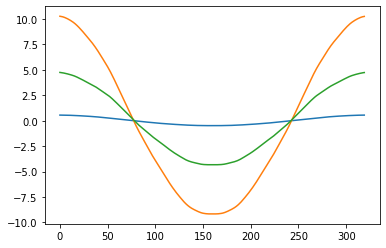

In [25]:
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['A'].iloc[0,:-1]);
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['B'].iloc[0,:-1]);
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['C'].iloc[0,:-1]);

In [28]:
cum_data_dict['cycle_1_I_30db']['cum2']['A']['fault_type'][1]

'CAT'

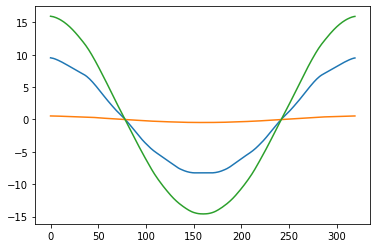

In [27]:
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['A'].iloc[1,:-1]);
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['B'].iloc[1,:-1]);
plt.plot(cum_data_dict['cycle_1_I_30db']['cum2']['C'].iloc[1,:-1]);

In [31]:
with open(data_path + 'data_cumulantes.pkl','wb') as f:
    data = pickle.dump(cum_data_dict, f)

In [33]:
with open(data_path + 'data_cumulantes.pkl','rb') as f:
    teste = pickle.load(f)

In [34]:
teste.keys()

dict_keys(['cycle_1_I_pu', 'cycle_1_I_30db', 'cycle_1_I_40db', 'cycle_1_I_50db', 'cycle_1_I_60db', 'cycle_1_I_70db', 'cycle_1_I_80db', 'cycle_1_I_90db', 'cycle_1_I_100db', 'cycle_2_I_pu', 'cycle_2_I_30db', 'cycle_2_I_40db', 'cycle_2_I_50db', 'cycle_2_I_60db', 'cycle_2_I_70db', 'cycle_2_I_80db', 'cycle_2_I_90db', 'cycle_2_I_100db', 'cycle_4_I_pu', 'cycle_4_I_30db', 'cycle_4_I_40db', 'cycle_4_I_50db', 'cycle_4_I_60db', 'cycle_4_I_70db', 'cycle_4_I_80db', 'cycle_4_I_90db', 'cycle_4_I_100db', 'cycle_8_I_pu', 'cycle_8_I_30db', 'cycle_8_I_40db', 'cycle_8_I_50db', 'cycle_8_I_60db', 'cycle_8_I_70db', 'cycle_8_I_80db', 'cycle_8_I_90db', 'cycle_8_I_100db', 'cycle_16_I_pu', 'cycle_16_I_30db', 'cycle_16_I_40db', 'cycle_16_I_50db', 'cycle_16_I_60db', 'cycle_16_I_70db', 'cycle_16_I_80db', 'cycle_16_I_90db', 'cycle_16_I_100db', 'cycle_32_I_pu', 'cycle_32_I_30db', 'cycle_32_I_40db', 'cycle_32_I_50db', 'cycle_32_I_60db', 'cycle_32_I_70db', 'cycle_32_I_80db', 'cycle_32_I_90db', 'cycle_32_I_100db'])